In [29]:
import time
import numpy as np
import cv2
import torch

from utils.datasets import letterbox
from utils.models import Darknet
from utils.parse_config import parse_data_cfg
from utils.utils import load_classes
from Utils_orientation import *

# Image path
base_file = 'figures/' + str(71) + '.jpg'
rotate_file = 'figures/' + str(99) + '.jpg'

# Configuration file path
cfg = 'cfg/yolov3-spp.cfg'
data_cfg = 'cfg/coco.data'
weights = 'cfg/best.pt'
data ='cfg/coco.data'
# Model parameter
img_size=640
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Initialize model and load weights
model = Darknet(cfg, img_size)
model.load_state_dict(torch.load(weights, map_location=device)['model'])
model.to(device).eval()

print(model)

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (Conv2d): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (Conv2d): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [54]:
conf_thres = 0.5
nms_thres = 0.5
# Preprocess the image
img0 = cv2.imread(base_file)
# Padded resize
img, _, _, _, _ = letterbox(img0)
# Normalize RGB
img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB
img = np.ascontiguousarray(img, dtype=np.float32)  # uint8 to float32
img /= 255.0  # 0 - 255 to 0.0 - 1.0
# Get detections
img = torch.from_numpy(img).unsqueeze(0).to(device)
with torch.no_grad():
    pred, _ = model(img)
    
detections = non_max_suppression(pred, conf_thres, nms_thres)[0]

In [62]:
torch.set_printoptions(sci_mode= False)

classes = load_classes(parse_data_cfg(data)['names'])
# Rescale the detection into original size
scale_coords(img.shape[2:], detections[:, :4], img0.shape).round()

for c in detections[:, -1].unique():
    n = (detections[:, -1] == c).sum()
    print('%g %ss' % (n, classes[int(c)]), end=', ')

tensor([[  640.00000,   314.94379,   640.00000,   360.00000,     0.90925,     0.99159,    63.00000],
        [  640.00000,    47.47971,   640.00000,   324.74341,     0.89110,     0.99567,    64.00000],
        [  640.00000,   360.00000,   640.00000,   360.00000,     0.81424,     0.99403,     0.00000],
        [  640.00000,     0.00000,   640.00000,   360.00000,     0.74723,     0.82409,    26.00000],
        [  640.00000,     0.00000,   640.00000,   360.00000,     0.58283,     0.96287,     0.00000]], device='cuda:1')
tensor([[  640.00000,   360.00000,   640.00000,   360.00000,     0.90925,     0.99159,    63.00000],
        [  640.00000,    56.12264,   640.00000,   360.00000,     0.89110,     0.99567,    64.00000],
        [  640.00000,   360.00000,   640.00000,   360.00000,     0.81424,     0.99403,     0.00000],
        [  640.00000,     0.00000,   640.00000,   360.00000,     0.74723,     0.82409,    26.00000],
        [  640.00000,     0.00000,   640.00000,   360.00000,     0.58283,

In [20]:
# Detection Process Transform tensor into numpy array
if device == torch.device("cpu"):
    detection_base = object_detection(model, base_file).numpy()
    detection_rotate = object_detection(model, rotate_file).numpy()
else:
    detection_base = object_detection(model, base_file).cpu().numpy()
    detection_rotate = object_detection(model, rotate_file).cpu().numpy()
    
# Image Orientation Calculation
show_results = True
show_images = True
mode = "SIFT"
# The index of object using to calculation the capture image
detection_index = 2

ValueError: too many values to unpack (expected 4)

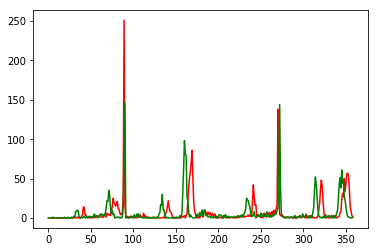

Final result: 
[     7.5247       7.583       7.746      8.1511      7.8967      7.5499      6.9844      9.4071      6.8904      6.7804]


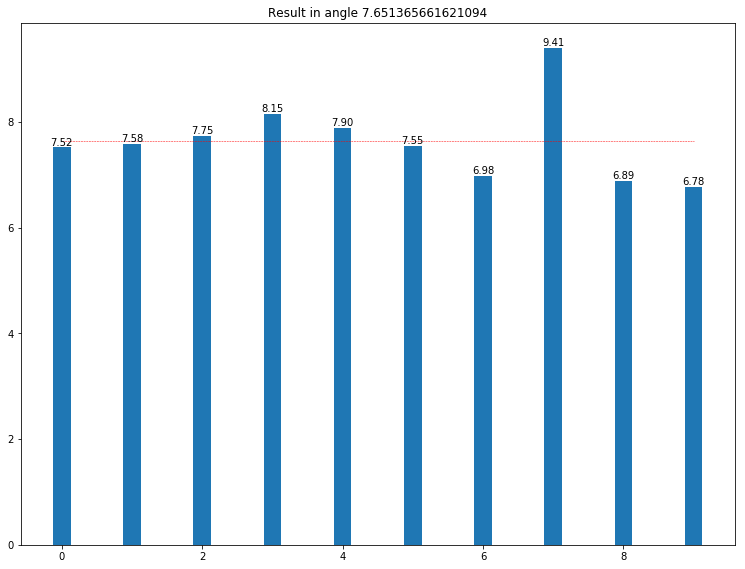

SIFTreal Result: median( 7.651), mean( 7.651) in 0.103


In [2]:
img_base, img_rotate = object_capture(base_file, rotate_file)
histogram_gradient(img_base, img_rotate, mag_thres= 80, bin_num= 360)
median, mean, time = angle_cal(img_base, img_rotate, mode, show_results= show_results, show_images= show_images)
print(mode + "real Result: median({0:6.3f}), mean({1:6.3f}) in {2:.3f}".format(median, mean, time))

In [1]:
for detection_index in range(4):
    img_base, img_rotate = object_capture(base_file, rotate_file,
                       bool_cap = True, detection_index = detection_index,
                       detection_base = detection_base, detection_rotate = detection_rotate)
    histogram_gradient(img_base, img_rotate, mag_thres= 20, bin_num= 360)
    median, mean, time = angle_cal(img_base, img_rotate, mode, show_results= show_results, show_images= show_images)
    print(mode + "real Result: median({0:6.3f}), mean({1:6.3f}) in {2:.3f}".format(median, mean, time))

NameError: name 'object_capture' is not defined